In [1]:
# import pandas as pd

# # df_ = pd.read_excel("Total.xlsx", index_col=None)

# df = pd.ExcelFile("Total.xlsx")
# print(df.sheet_names)
# df1 = pd.read_excel(df, '1st')
# df2 = pd.read_excel(df, '2nd')
# df3 = pd.read_excel(df, '3rd')
# df_ = pd.concat([df1,df2,df3],axis=0)

# cluster = df_['Cluster'].str.split(' ', n=1, expand=True)
# cluster = cluster.rename(columns={0:'cluster', 1:'kPa'})
# features = df_.drop('Cluster', axis=1)

# df_ = pd.concat([features, cluster], axis=1)
# df_.reset_index(drop=True, inplace=True)
# df_.to_csv('Total.csv', index=False)
# print(df_)

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
# np.random.seed(42)

df = pd.read_csv('Total.csv', index_col = None)
columns_new = dict([(name, name.replace('.','__')) for name in df.columns])
df.rename(columns=columns_new, inplace=True)


print(df['kPa'].unique())
kPa = '22kPa'
df_ = df[df['kPa']==kPa]
X = df_.drop(["ID", "cluster","kPa"], axis=1) # Independent variables
# X = X.iloc[:,feature_selected]
y_ = df_.cluster # Dependent variable

y = np.zeros(y_.shape)
y[y_=='TIF'] = 1
y = pd.DataFrame(y, columns=['cluster'], dtype=float)
# y_.loc[y_=='CAF'] = 0
# y_.loc[y_=='TIF'] = 1
# y = y_.astype(float)


X_columns_new = dict([(name, f'ind_{i}_'+name) for i,name in enumerate(X.columns)])
X.rename(columns=X_columns_new, inplace=True)
features = np.array(X.columns)

# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

['1kPa' '4kPa' '6kPa' '22kPa' '60kPa' '0.5kPa']


In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train.iloc[:,:] = scaler.transform(X_train)
X_test.iloc[:,:] = scaler.transform(X_test)

X_train.shape

(272, 149)

In [76]:
### initialize selected features
unique = np.arange(X_train.shape[1])  

###1kPa LR not used
# unique = np.array([104,   2,  63,  11,  10,  67,   1,  38,   7,  13, 105,  91, 148, 36, 112,   3,  19,  53, 147,  56,  87,  12, 132]) 
# unique = np.array([113,   1,   9, 105,   7, 106,  20,  86,  28,  57, 148, 141,  33, 43, 111,  87,  44,  91,  30, 100])## 4kPa
# unique = np.array([  3,   1,  14, 105, 148,  90,  20, 107,  82,  43,  56,  33, 101, 34,  41,  28])## 6kPa
# unique = np.array([ 11,   1,  43,   7,  98,  38,   2,  30,   4,  84,  50, 106,  87, 105,  33,  34,  19,  41,  28,  62, 131,  46, 104,  70, 132,  57, 67]) ##22kPa
# array([ 11,   1,   7,  98,  38, 106,  84,  30,  43,  33,  19,  87,  34, 4])
# unique = np.array([113,   9, 105,   1, 131,  20,  86,  33,  28,  43]) ## 4kPa

In [127]:
from model import get_importance_index

scoring = 'roc_auc'
ranked_idx, importance_score, F1 = get_importance_index(X_train.iloc[:,unique], y_train, X_test.iloc[:,unique], y_test, scoring)

/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}
Logistic regression: 
              precision    recall  f1-score   support

         0.0       0.84      0.83      0.83        64
         1.0       0.80      0.81      0.80        53

    accuracy                           0.82       117
   macro avg       0.82      0.82      0.82       117
weighted avg       0.82      0.82      0.82       117



The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
XGBoost: 
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87        64
         1.0       0.83      0.85      0.84        53

    accuracy                           0.85       117
   macro avg       0.85      0.85      0.85       117
weighted avg       0.86      0.85      0.85       117

{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
Random Forest: 
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88        64
         1.0       0.86      0.83      0.85        53

    accuracy                           0.86       117
   macro avg       0.86      0.86      0.86       117
weighted avg       0.86      0.86      0.86       117



In [128]:
# percent = importance_score/importance_score.sum(0)

# percent.sort(axis=0)
# # plt.plot(percent[::-1,2])
# # print(np.cumsum(percent, axis=0))
# plt.plot(np.cumsum(percent[::-1],axis=0))


In [129]:
epoch = 5
remove_group_num = np.array([50,32,15, 7,3,1,1,1,1,1,1])
remove_order_num = np.array([10, 8, 5, 3,2,1,1,1,1,1,1])  #60,40,20,10,5,2,2,2,2,2,2
assert X_train.shape[1]==149
remove = 149-np.cumsum(remove_group_num+remove_order_num)

ranked_idx = ranked_idx[:,F1>.8]
ranked_idx_ = unique[ranked_idx.flatten()]
# ranked_idx = ranked_idx[:int(ranked_idx.shape[0]*3/4)] ## remove low ranking features

In [130]:
unique_rank = []
for i in ranked_idx_.flatten():
    if i not in unique_rank:
        unique_rank.append(i)

unique_rank = np.array(unique_rank)[:-remove_order_num[epoch]]
unique_rank, unique_rank.shape
# unique = unique[current_idx]

(array([98,  1, 11, 38, 43,  2,  7, 50, 87, 30, 94]), (11,))

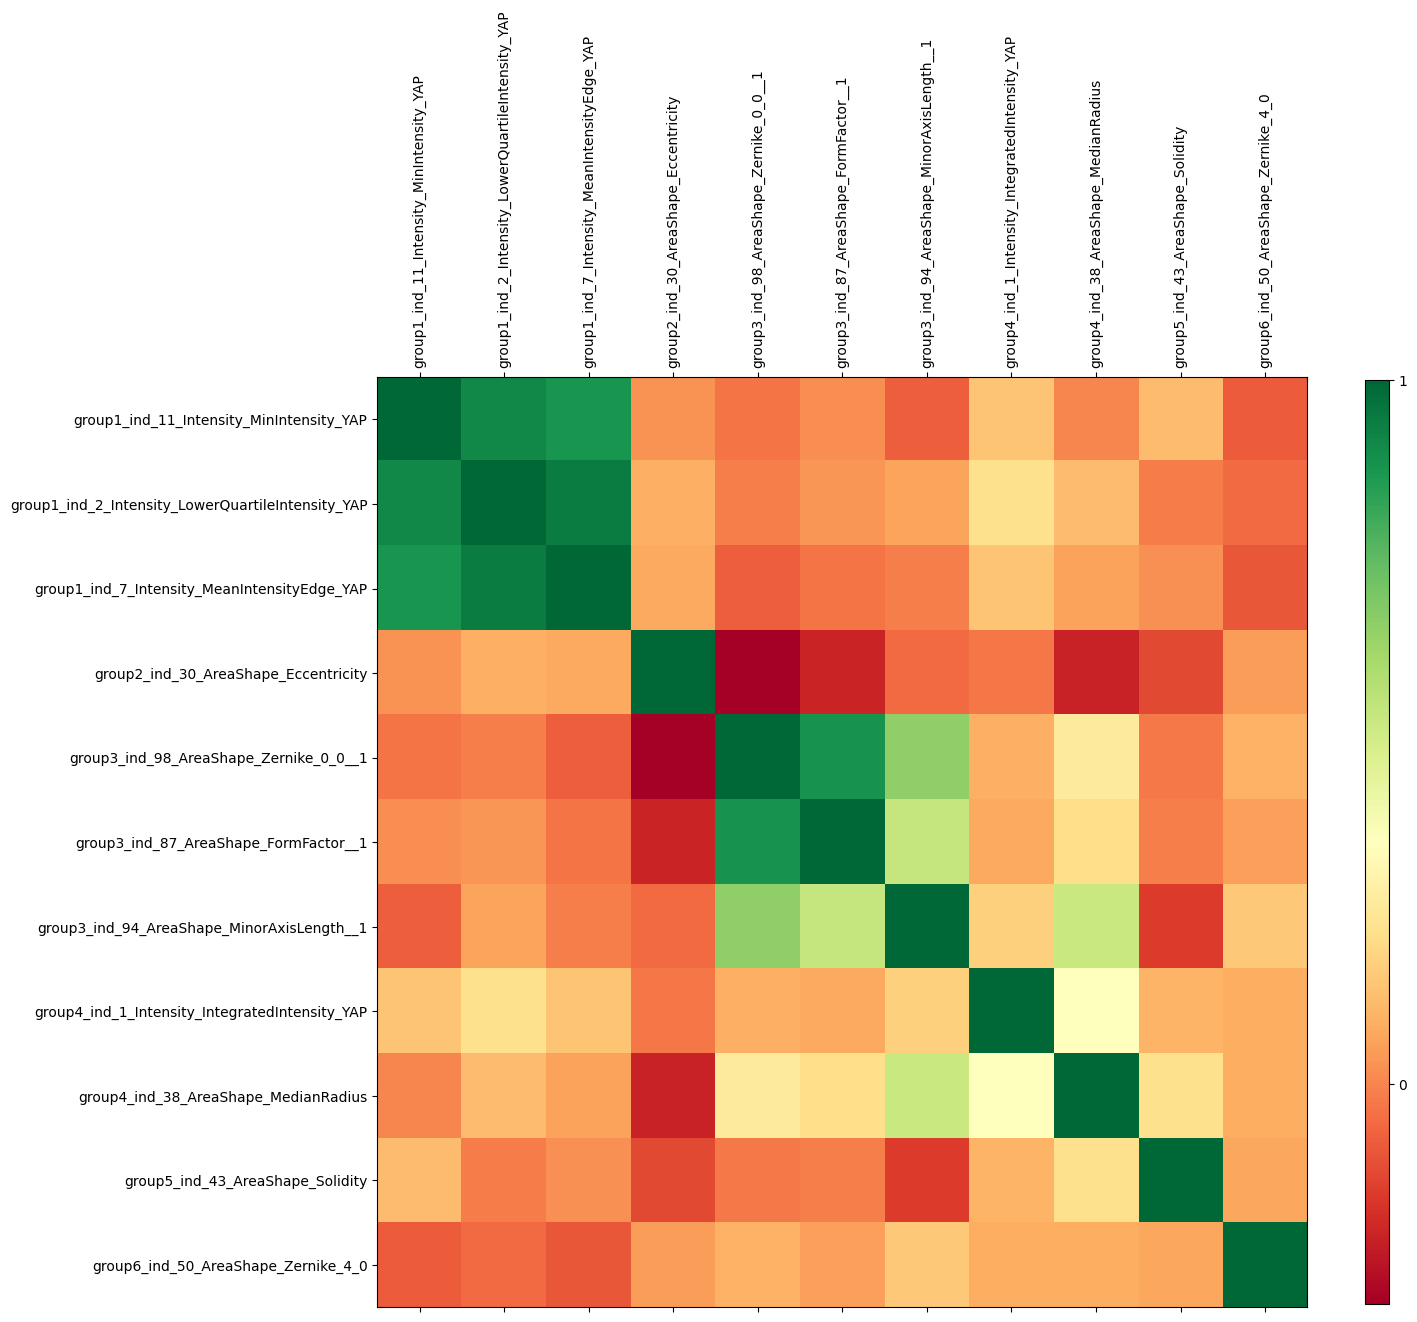

In [131]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

# plot_corr(selected)

import scipy
import scipy.cluster.hierarchy as sch

selected = X.iloc[:, unique_rank]

corr_values = selected.corr().values
d = sch.distance.pdist(corr_values)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [selected.columns.tolist()[i] for i in list((np.argsort(ind)))]
selected_sorted = selected.reindex(columns, axis=1)

selected_columns_new = dict([(name, f'group{i}_'+name) for i,name in zip(np.sort(ind),selected_sorted.columns)])
selected_sorted.rename(columns=selected_columns_new, inplace=True)

plot_corr(selected_sorted, size=15)

In [132]:
group_member = []
for i in np.unique(ind):
    group_member.append(unique_rank[ind==i])

for i in group_member:
    print(i)


[11  2  7]
[30]
[98 87 94]
[ 1 38]
[43]
[50]


In [133]:
### select percent(per) of current feature, spread in each group has num features
num = remove_group_num[epoch]//np.unique(ind).shape[0]+1
print(num)

unique_ = []
for member in group_member:
    unique_.extend(list(member[:-num]))

unique_ = np.array(unique_)[:remove[epoch]]
print(unique_.shape)


extra = []
for i in unique_rank:
    if i not in unique_:
        extra.append(i)
    if len(extra) == remove[epoch]-unique_.shape[0]:
        break
    
unique_ = np.r_[unique_, extra]
print(unique_.shape)

1
(5,)
(11,)


In [134]:
unique = unique_

In [ ]:
selected_sorted.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
selected_y = pd.concat([selected_sorted,y], axis=1)


## get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

status_name = 'cluster'
anova_list = list(selected_sorted.columns)
    
pvalue = {}
pvalue_problem = {}
for cov in anova_list:
    # Ordinary Least Squares (OLS) model
    model = ols(f'{status_name} ~ {cov}', data=selected_y).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    _pvalue = anova_table['PR(>F)'][cov]
    pvalue[cov] = _pvalue

    if _pvalue>.05:
        print(f'{cov}: {_pvalue}')
        pvalue_problem[cov] = _pvalue
        
# print(pvalue_problem)

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np



import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
# np.random.seed(42)



def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    # %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

# plot_corr(selected)

import scipy.cluster.hierarchy as sch
def feature_extraction(X_train, y_train, X_test, y_test, X):

    assert X_train.shape[1]==149
    remove_group_num = np.array([50,32,15, 7,3,1,1,1,1,1,1])
    remove_order_num = np.array([10, 8, 5, 3,2,1,1,1,1,1,1])  #60,40,20,10,5,2,2,2,2,2,2
    remove = 149-np.cumsum(remove_group_num+remove_order_num)


    from model import get_importance_index
    unique = np.arange(X_train.shape[1])  

    F1_list, idx_list = [], []
    for epoch in range(remove_order_num.shape[0]):

        ################ feature importance ranking #################
        scoring = 'roc_auc'
        ranked_idx, importance_score, F1 = get_importance_index(X_train.iloc[:,unique], y_train, X_test.iloc[:,unique], y_test, scoring)
        #############################################################


        ############### remove features by importance ranking ##################
        ranked_idx = ranked_idx[:,F1>.8]
        ranked_idx_ = unique[ranked_idx.flatten()]

        unique_rank = []
        for i in ranked_idx_.flatten():
            if i not in unique_rank:
                unique_rank.append(i)

        unique_rank = np.array(unique_rank)[:-remove_order_num[epoch]]
        # unique_rank, unique_rank.shape
        ########################################################################
        F1_list.append(F1)
        idx_list.append(unique_rank)

        ############### group selected feature by correlation values ################
        selected = X.iloc[:, unique_rank]

        corr_values = selected.corr().values
        d = sch.distance.pdist(corr_values)   # vector of ('55' choose 2) pairwise distances
        L = sch.linkage(d, method='complete')
        ind = sch.fcluster(L, 0.5*d.max(), 'distance')
        columns = [selected.columns.tolist()[i] for i in list((np.argsort(ind)))]
        selected_sorted = selected.reindex(columns, axis=1)

        selected_columns_new = dict([(name, f'group{i}_'+name) for i,name in zip(np.sort(ind),selected_sorted.columns)])
        selected_sorted.rename(columns=selected_columns_new, inplace=True)
        # plot_corr(selected_sorted, size=15)
        ############################################################################


        ########################### remove features by groups(avoid selected features highly correlated) ###############
        group_member = []
        for i in np.unique(ind):
            group_member.append(unique_rank[ind==i])
        # for i in group_member:
        #     print(i)

        ### select percent(per) of current feature, spread in each group has num features
        num = remove_group_num[epoch]//np.unique(ind).shape[0]+1
        # print(num)

        unique_ = []
        for member in group_member:
            unique_.extend(list(member[:-num]))
        unique_ = np.array(unique_)[:remove[epoch]]
        # print(unique_.shape)

        extra = []
        for i in unique_rank:
            if i not in unique_:
                extra.append(i)
            if len(extra) == remove[epoch]-unique_.shape[0]:
                break
            
        unique_ = np.r_[unique_, extra]
        # print(unique_.shape)
        ################################################################################################################

        unique = unique_

    return F1_list, idx_list


def get_data(df_):
    # kPa = '22kPa'
    # df_ = df[df['kPa']==kPa]
    X = df_.drop(["ID", "cluster","kPa"], axis=1) # Independent variables
    # X = X.iloc[:,feature_selected]
    y_ = df_.cluster # Dependent variable

    y = np.zeros(y_.shape)
    y[y_=='TIF'] = 1
    y = pd.DataFrame(y, columns=['cluster'], dtype=float)
    # y_.loc[y_=='CAF'] = 0
    # y_.loc[y_=='TIF'] = 1
    # y = y_.astype(float)


    X_columns_new = dict([(name, f'ind_{i}_'+name) for i,name in enumerate(X.columns)])
    X.rename(columns=X_columns_new, inplace=True)
    features = np.array(X.columns)

    # Split into train and test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train.iloc[:,:] = scaler.transform(X_train)
    X_test.iloc[:,:] = scaler.transform(X_test)

    X_train.shape

    return X_train, y_train, X_test, y_test, X, features


df = pd.read_csv('Total.csv', index_col = None)
columns_new = dict([(name, name.replace('.','__')) for name in df.columns])
df.rename(columns=columns_new, inplace=True)

kPa_list = df['kPa'].unique()
kPa_list

In [2]:
F1_kPa, idx_kPa = [], []
for kPa in kPa_list:
# for kPa in ['22kPa']:
    df_ = df[df['kPa']==kPa]
    X_train, y_train, X_test, y_test, X, features = get_data(df_)
    F1_list, idx_list = feature_extraction(X_train, y_train, X_test, y_test, X)
    
    F1_kPa.append(F1_list)
    idx_kPa.append(idx_list)

{'C': 0.5, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.66676418 0.84608641 0.82051282]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.63151098 0.86318792 0.87179487]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.57277446 0.84608641 0.86318792]
{'C': 2.0, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.57189984 0.84608641 0.85476456]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.1, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.54714107 0.84608641 0.83744071]
{'C': 0.1, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.53846154 0.86328783 0.84608641]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.1, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.54621062 0.85476456 0.8289849 ]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.1, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.52157745 0.8203292  0.8289849 ]
{'C': 0.1, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.52991453 0.84608641 0.8461988 ]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.1, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.54654513 0.85470085 0.8461988 ]
{'C': 0.5, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l2', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.36697014 0.87166372 0.83760684]
{'C': 2.0, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.78447852 0.84988648 0.82230513]
{'C': 2.0, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.77534578 0.86895171 0.84070152]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.79406697 0.87818351 0.83150934]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.74699652 0.85944251 0.85906906]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.73650825 0.88707497 0.89630097]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.73650825 0.92494324 0.89692451]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.73650825 0.92494324 0.89665064]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.001}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.76432038 0.92471664 0.91544143]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.68004573 0.89630097 0.90617905]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.71386091 0.85971458 0.84120502]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.71535524 0.87818351 0.86915888]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.001}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.92917025 0.92027904 0.8848475 ]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


{'C': 2.0, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.001}


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.92917025 0.92917025 0.8848475 ]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.92917025 0.92027904 0.87604794]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.83183206 0.83170019 0.82273109]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.83183206 0.84063306 0.84063306]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 250, 'penalty': 'l1', 'tol': 0.001}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.80527924 0.83146225 0.82292562]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.83183206 0.82273109 0.83183206]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.001}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.83183206 0.84889441 0.84941596]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.81407194 0.82273109 0.81398442]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.80527924 0.86667154 0.84045798]
{'C': 1.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.78757735 0.85818487 0.82273109]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 2, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.86354811 0.8720207  0.87103135]
{'C': 2.0, 'fit_intercept': False, 'max_iter': 500, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.86352859 0.85480778 0.86220691]
{'C': 2.0, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.86352859 0.86342875 0.86220691]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 250, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.80382137 0.88058751 0.83710135]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.82943514 0.88058751 0.86263845]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.81235181 0.87207658 0.86298488]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.82941073 0.8806046  0.85480778]
{'C': 2.0, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.82090721 0.8720207  0.8206449 ]
{'C': 2.0, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.81221453 0.79514313 0.8028069 ]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 250, 'penalty': 'l1', 'tol': 0.001}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.78670117 0.83772634 0.81944389]
{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.75231915 0.81221453 0.81160421]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 1.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.79925842 0.88421948 0.85498289]
{'C': 1.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.7897207  0.88372917 0.86366479]
{'C': 1.0, 'fit_intercept': False, 'max_iter': 250, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
LR, XGBoost, RF:  [0.79911533 0.90351623 0.89365412]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.79910609 0.93201112 0.91258573]
{'C': 1.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.78014017 0.95166096 0.89316033]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.77965624 0.94210974 0.89365412]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.77965624 0.90310765 0.89365412]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.76085158 0.90310765 0.89316033]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.76085158 0.90351623 0.88372917]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-pack

{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.75139978 0.88461538 0.87431851]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.5, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.72278543 0.85498289 0.87431851]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.5, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.82159845 0.85319746 0.86110483]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.5, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.82159845 0.84476422 0.89378604]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.5, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.83739837 0.83688607 0.86950885]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-pack

{'C': 0.5, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
LR, XGBoost, RF:  [0.83739837 0.82901182 0.87744543]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-pack

{'C': 0.5, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.82989102 0.85319746 0.84529641]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-pack

{'C': 2.0, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.84529641 0.83781677 0.86950885]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 0.001}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.85454224 0.85403509 0.87695187]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-pack

{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'tol': 1e-05}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': False, 'max_depth': 70, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.83852876 0.83781677 0.86110483]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.5, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 1e-05}


Liblinear failed to converge, increase the number of iterations.
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.84573821 0.85319746 0.88582025]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-pack

{'C': 1.0, 'fit_intercept': True, 'max_iter': 250, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
LR, XGBoost, RF:  [0.86197629 0.87025342 0.86197629]


/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dliu/miniconda3/envs/py38/lib/python3.8/site-pack

{'C': 2.0, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

{'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 1.0}
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}
LR, XGBoost, RF:  [0.87786558 0.87025342 0.86197629]


In [1]:
import pickle

# with open('F1_kPa', 'wb') as file:
#     pickle.dump(F1_kPa, file)

# with open('idx_kPa', 'wb') as file:
#     pickle.dump(idx_kPa, file)



with open('F1_kPa', 'rb') as file:
    F1_kPa = pickle.load(file)

with open('idx_kPa', 'rb') as file:
    idx_kPa = pickle.load(file)

In [3]:
kPa_list = df['kPa'].unique()

kPa_list

array(['1kPa', '4kPa', '6kPa', '22kPa', '60kPa', '0.5kPa'], dtype=object)

In [4]:
i = 0
F1_list, idx_list = F1_kPa[i], idx_kPa[i]
for F1, idx_ordered in zip(F1_list[1:], idx_list[1:]):
    print(f'{kPa_list[i]} mean f1 score: {F1.mean():.2f}, F1 score: {F1}')
    print(f'selected idx: {idx_ordered}')

1kPa mean f1 score: 0.79, F1 score: [0.63151098 0.86318792 0.87179487]
selected idx: [  2  10  11   1  13   7  36   9   4   8  43  14  91 122  82   3  65  38
  32  92 132  37  19  90  51 147 110 135  39  28  94  58  63   0  40  56
  74 148  12  49  85 119  22  15 131  95  68  29  99 106 130  62 142  84
 116 128  25  47 124 137 141  54  23  46 101  67  79  53  72  16 127   5
  60 115  24 121  61  69  26  30 126]
1kPa mean f1 score: 0.76, F1 score: [0.57277446 0.84608641 0.86318792]
selected idx: [  2  10  11   1  13   9  36   7   4 122   3  51  91  82  38  92  65  37
 132 110  39 130  94  15 135  49 131  22  90  63  12 119  56  47 124  99
  62 116  95 106  79  25  53  16]
1kPa mean f1 score: 0.76, F1 score: [0.57189984 0.84608641 0.85476456]
selected idx: [  2  10  11   1  13  36   9   4   7  91  15  37  51   3 132  38  82  92
  94 122  65 110  39 130  49  47]
1kPa mean f1 score: 0.74, F1 score: [0.54714107 0.84608641 0.83744071]
selected idx: [  2  10  11   1   4  36   9  13  91  92  1

In [5]:
i = 1
F1_list, idx_list = F1_kPa[i], idx_kPa[i]
for F1, idx_ordered in zip(F1_list[1:], idx_list[1:]):
    print(f'{kPa_list[i]} mean f1 score: {F1.mean():.2f}, F1 score: {F1}')
    print(f'selected idx: {idx_ordered}')

4kPa mean f1 score: 0.83, F1 score: [0.77534578 0.86895171 0.84070152]
selected idx: [  1   9  86   2  10   7 106  20 113  11   8  68  28  33  87  43  82 141
 105 148   4 118   0  14 117 134 142  94  24  52  91 100 131  58  84 128
  98 111  90 140  35  92  59  57 122   3  83  74 119  93 107  97  51 120
 116  60 137 103  47  95  44  12  56  67 130 108  69 136  48  99   5 115
  22  78 114 129  70  26  53 109  73]
4kPa mean f1 score: 0.83, F1 score: [0.79406697 0.87818351 0.83150934]
selected idx: [  1   9  86   2  10 106  20   7  11 113   8  68  28  33  43  82 141 148
 105 117  87 142 134  14 118  91  24  94  52  90 128 116  58 107  59  60
 119  67 103  95  98  57  22  47]
4kPa mean f1 score: 0.82, F1 score: [0.74699652 0.85944251 0.85906906]
selected idx: [  1.   9.  86.   2.  20. 106. 113.  10.   7.  33.  68.  87. 134.  11.
   8. 142.  43.  94. 118. 117.  91.  24.  58.  60. 107. 119.]
4kPa mean f1 score: 0.84, F1 score: [0.73650825 0.88707497 0.89630097]
selected idx: [  1.   9. 106.  

In [35]:
i = 2
F1_list, idx_list = F1_kPa[i], idx_kPa[i]
for F1, idx_ordered in zip(F1_list[1:], idx_list[1:]):
    print(f'{kPa_list[i]} mean f1 score: {F1.mean():.2f}, F1 score: {F1}')
    print(f'selected idx: {idx_ordered[:50]}')

6kPa mean f1 score: 0.91, F1 score: [0.92917025 0.92917025 0.8848475 ]
selected idx: [148   1   3   9   7  14  41   8   2  90 105  56  13 113  20  10 141 142
  12  19  11 122 106  97   0 131 135  84  87  86  98 140  82  43 147 107
  93  38  94  91  33 111  63 128  22 123 118 133  95   4]
6kPa mean f1 score: 0.91, F1 score: [0.92917025 0.92027904 0.87604794]
selected idx: [148   1   3   9  41   8  14   7 105  90  13  56   2 113  20   0 141 142
  87  12  19  10 122  97  93  84 106  11 147 131  86  82  98  43 135  38
  91 123 107 128 140  33   4 118  63 139  22 111   5  95]
6kPa mean f1 score: 0.83, F1 score: [0.83183206 0.83170019 0.82273109]
selected idx: [  3.  13. 148. 105.  52. 131. 113. 141.  86.  87.  12.  98.  56. 122.
  51. 120. 110. 111. 101. 118.  15. 121. 119.  24.  22.  50.]
6kPa mean f1 score: 0.84, F1 score: [0.83183206 0.84063306 0.84063306]
selected idx: [  3.  86. 148. 105. 131. 113.  13.  52. 141.  56.  87.  12. 122.  15.
 120. 110. 111.]
6kPa mean f1 score: 0.82, F1 sc

In [30]:
i = 3
F1_list, idx_list = F1_kPa[i], idx_kPa[i]
for F1, idx_ordered in zip(F1_list[1:], idx_list[1:]):
    print(f'{kPa_list[i]} mean f1 score: {F1.mean():.2f}, F1 score: {F1}')
    print(f'selected idx: {idx_ordered}')

22kPa mean f1 score: 0.86, F1 score: [0.86352859 0.85480778 0.86220691]
selected idx: [ 11   1   2  98   4  10   7  43  38  40  50  87  30  57  20  93  33  39
   9  62  31  41 129  94  44 127 100  91   3  27  70  34  90  67  37 123
 108  55 104  19  36 101 138  86  74  92  46 116 139  65  68  85  48 147
  47  35 107 124  32  58  71  66  52  83   6 120  42 134 121  13 119  95
 130 111 133  54  99  45 126  49  22]
22kPa mean f1 score: 0.86, F1 score: [0.86352859 0.86342875 0.86220691]
selected idx: [ 98   1   2  11   7   4  50  38  10  30  43  87  94  41  20  40  57   9
 129  93  34  62  33  44 108  70  91 123   3  39  90 100  31 101  37  67
  19  36 127  65 138  55 120 139]
22kPa mean f1 score: 0.84, F1 score: [0.80382137 0.88058751 0.83710135]
selected idx: [ 98   1  11   7  50   2  38   4  30  43  20  94  41  34  40  57 129  33
  93 108  44  62  39 100  70 101]
22kPa mean f1 score: 0.86, F1 score: [0.82943514 0.88058751 0.86263845]
selected idx: [ 98   1  11   2  50  94  38   7   4  2

In [31]:
i = 4
F1_list, idx_list = F1_kPa[i], idx_kPa[i]
for F1, idx_ordered in zip(F1_list[1:], idx_list[1:]):
    print(f'{kPa_list[i]} mean f1 score: {F1.mean():.2f}, F1 score: {F1}')
    print(f'selected idx: {idx_ordered}')

60kPa mean f1 score: 0.85, F1 score: [0.7897207  0.88372917 0.86366479]
selected idx: [  1 105  87 148  84  82   3  98   2   0   9  14   8  37 120  88 101  11
  97  20  10 135  93  70  38 130  94 132  31  58  49  64  89  36  90 133
  86   7  65 139 107  71 141  50  40  99  12   6 138 112  53   5  57 102
 111  13  91  29 137  39 104  61 125  47  67 123 126  81  45  69 108  68
 109  18  16 127  48  52  60  62  63]
60kPa mean f1 score: 0.87, F1 score: [0.79911533 0.90351623 0.89365412]
selected idx: [  1 105  87  98 148   3   0  37   2   8  14   9  97  86  20  11 135  10
  94 132  58   7  70  93  65  31 130 139  36 107  38  99  49   6  71 133
  50  47  64  53  45 102  69  61]
60kPa mean f1 score: 0.88, F1 score: [0.79910609 0.93201112 0.91258573]
selected idx: [  1  87  98  11   8  37   2   3  20   9  14 107  97 130  70  86  31   6
 132 135  65   7  58  47  10  71]
60kPa mean f1 score: 0.87, F1 score: [0.78014017 0.95166096 0.89316033]
selected idx: [  1  87  98  11  37  14   2   3   8  2

In [32]:
i = 5
F1_list, idx_list = F1_kPa[i], idx_kPa[i]
for F1, idx_ordered in zip(F1_list[1:], idx_list[1:]):
    print(f'{kPa_list[i]} mean f1 score: {F1.mean():.2f}, F1 score: {F1}')
    print(f'selected idx: {idx_ordered}')

0.5kPa mean f1 score: 0.85, F1 score: [0.82159845 0.84476422 0.89378604]
selected idx: [ 11  10   2   7   1   9  83   8  64  14  19 138 139  46  86 128  54   0
 124   3 122  12  38  95  36 135  60  85 100 125 113  24 130  13  37  39
 101 132 136  40 103 106  68  74 126  61 142  65  55 123 127  84  75  59
   6  62 112  63  41   5   4 114  22 118 111 133 117 109 121 120  67 141
  69  82  70  71 107 119  53  17  15]
0.5kPa mean f1 score: 0.85, F1 score: [0.83739837 0.83688607 0.86950885]
selected idx: [ 10.  11.   2.   7.   1.   9.  83.   8.  24.  64.  14. 138. 139.  86.
   0.  46. 124.  54. 135. 125.  12.  38.   3.  36.  95. 122. 113. 103.
 100.  65.  60.  68. 106. 126. 101.  61. 112.  55. 111.  62.  84.  63.
  59. 123.]
0.5kPa mean f1 score: 0.85, F1 score: [0.83739837 0.82901182 0.87744543]
selected idx: [ 11.  10.   2.   9.   1.   7.   8.  64.  86.  24.  83.  14. 124. 138.
 139.   0. 100.  46.  60.  36.  54. 113. 122.  38. 125.  68.]
0.5kPa mean f1 score: 0.84, F1 score: [0.82989102 0

In [15]:
idx_26 = np.array(np.r_[[idx_[-8] for idx_ in idx_kPa]], dtype=int)
idx_17 = np.array(np.r_[[idx_[-7] for idx_ in idx_kPa]], dtype=int)
idx_13 = np.array(np.r_[[idx_[-6] for idx_ in idx_kPa]], dtype=int)
idx_11 = np.array(np.r_[[idx_[-5] for idx_ in idx_kPa]], dtype=int)
idx_9 = np.array(np.r_[[idx_[-4] for idx_ in idx_kPa]], dtype=int)
idx_7 = np.array(np.r_[[idx_[-3] for idx_ in idx_kPa]], dtype=int)
idx_5 = np.array(np.r_[[idx_[-2] for idx_ in idx_kPa]], dtype=int)
idx_3 = np.array(np.r_[[idx_[-1] for idx_ in idx_kPa]], dtype=int)

print(np.sort(idx_13,axis=1))
print(np.sort(idx_11,axis=1))


[[  1   2   4   9  10  11  13  15  36  37  51  82  91]
 [  1   2   7   8   9  10  20  33  68  86 106 113 134]
 [  3  12  13  52  56  86  87 105 113 122 131 141 148]
 [  1   2   4   7  11  20  30  38  40  43  50  94  98]
 [  1   2   3   8   9  11  14  20  37  70  87  98 130]
 [  0   1   2   7   8   9  10  11  14  24  54  83 100]]
[[  1   2   4   9  10  11  13  15  36  82  91]
 [  1   2   7   9  10  20  33  86 106 113 134]
 [  3  13  52  56  86 105 113 122 131 141 148]
 [  1   2   4   7  11  30  38  43  50  94  98]
 [  1   2   3   8   9  11  14  20  37  87  98]
 [  0   1   2   7   8   9  10  11  14  24  54]]


In [17]:
print(np.sort(idx_9,axis=1))
print(np.sort(idx_7,axis=1))
print(np.sort(idx_5,axis=1))

[[  1   2   4   9  10  11  13  36  82]
 [  1   2   7   9  10  20 106 113 134]
 [  3  13  56  86 105 113 131 141 148]
 [  1   2   7  11  38  43  50  94  98]
 [  1   2   8  11  14  20  37  87  98]
 [  0   1   2   7   8   9  10  11  24]]
[[  1   2   4  10  11  13  36]
 [  1   2   7   9  10  20 106]
 [  3  56  86 105 113 131 148]
 [  1   2  11  43  50  94  98]
 [  1   2   8  14  37  87  98]
 [  1   2   7   8   9  10  11]]
[[  1   2  10  11  13]
 [  1   7   9  10 106]
 [  3 105 113 131 148]
 [  1   2  11  43  98]
 [  1  14  37  87  98]
 [  2   7   9  10  11]]


In [18]:
df_ = df[df['kPa']==kPa_list[0]]
X_train, y_train, X_test, y_test, X, features = get_data(df_)

In [19]:
unique_13, count_13 = np.unique(idx_17, return_counts=True)
unique_13[count_13>4], features[unique_13[count_13>4]]

(array([ 1,  2, 11]),
 array(['ind_1_Intensity_IntegratedIntensity_YAP',
        'ind_2_Intensity_LowerQuartileIntensity_YAP',
        'ind_11_Intensity_MinIntensity_YAP'], dtype=object))

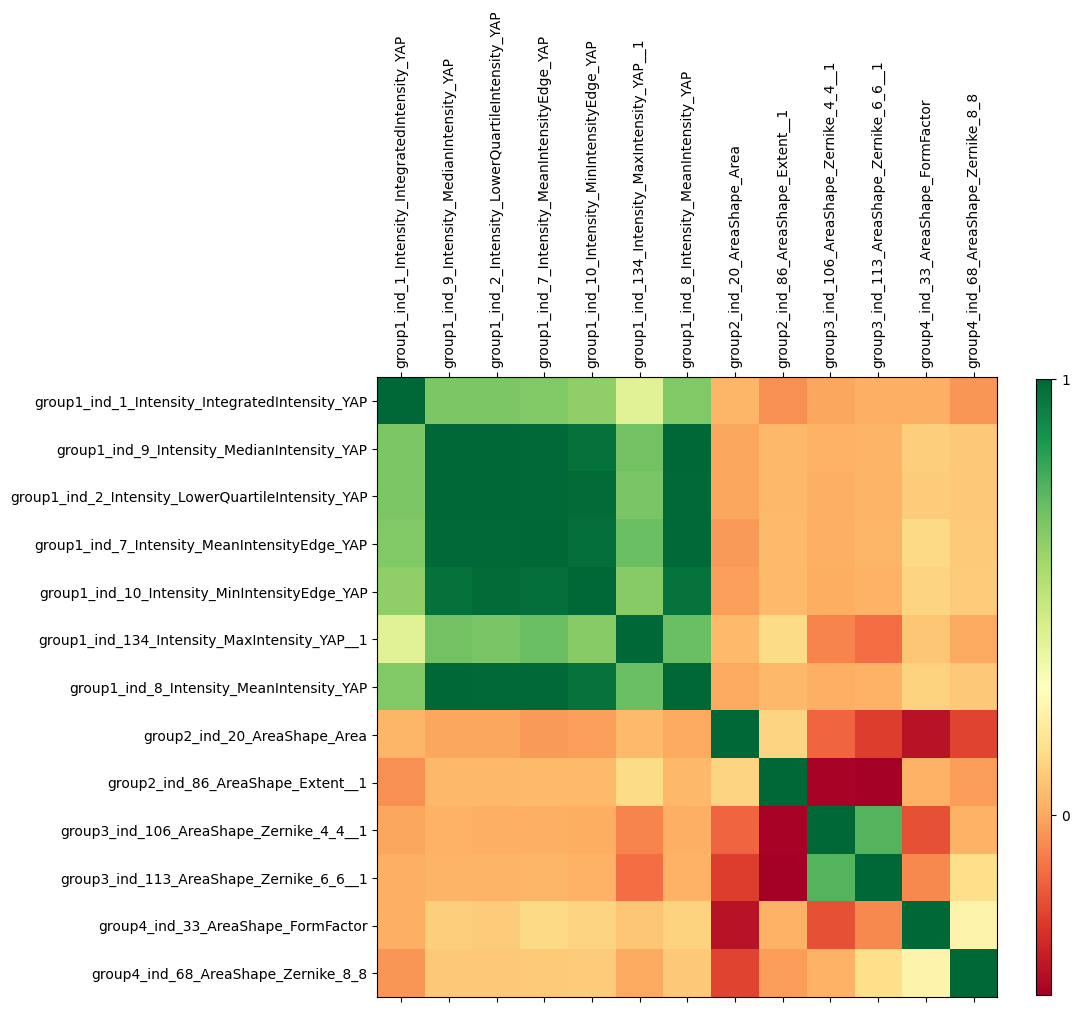

In [14]:
ii = 1
kPa_list = df['kPa'].unique()

df_ = df[df['kPa']==kPa_list[ii]]
X_train, y_train, X_test, y_test, X, features = get_data(df_)

selected = X.iloc[:, idx_13[ii]]
# selected = X.iloc[:, idx_11[ii]]
# selected = X.iloc[:, idx_9[ii]]
# selected = X.iloc[:, idx_7[ii]]
# selected = X.iloc[:, idx_5[ii]]

corr_values = selected.corr().values
d = sch.distance.pdist(corr_values)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [selected.columns.tolist()[i] for i in list((np.argsort(ind)))]
selected_sorted = selected.reindex(columns, axis=1)

selected_columns_new = dict([(name, f'group{i}_'+name) for i,name in zip(np.sort(ind),selected_sorted.columns)])
selected_sorted.rename(columns=selected_columns_new, inplace=True)

plot_corr(selected_sorted)